In [279]:
# plot the reward function with plotly as line plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Prepare test data

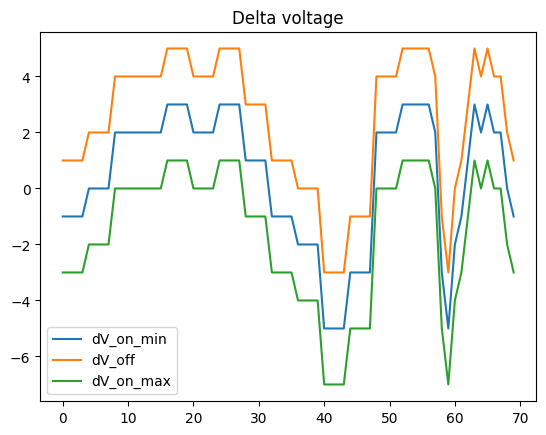

In [280]:
data = pd.read_csv('test_data/test_data_comb_variant_1.csv')

def calculate_voltage_delta(data):
    data['dV_on_min'] = data['voltage'] - data['target_voltage']
    data['dV_off'] = data['voltage_upper'] - data['target_voltage']
    data['dV_on_max'] = data['voltage_lower'] - data['target_voltage']
    return data

data = calculate_voltage_delta(data)

plt.title('Delta voltage')
plt.plot(data['dV_on_min'], label='dV_on_min')
plt.plot(data['dV_off'], label='dV_off')
plt.plot(data['dV_on_max'], label='dV_on_max')
plt.legend()
plt.show()

## Parameters
To change the reward function see *get_reward* function

In [281]:
device_min = 35
device_max = 90
n_states = device_max - device_min + 2
switching_penality = 40  # bigger means less switches

In [282]:
def get_reward(dV):
    # We want to be as close as possible to 0 to avoid being to close to the limits.
    # Being to close to the limit is bad because the voltages are not precisely known.
    precision_incentive = -0.01*np.abs(dV)
    if dV < 1 and dV > -1:
        return 3 + precision_incentive
    elif dV < 2 and dV > -2:
        return 0 + precision_incentive
    else:
        return -24.4 + precision_incentive
    
def get_state_switch_penality(i_from, i_to):
    if (i_from == 0 or i_to == 0) and i_from != i_to:  # is switch off or on
        return -switching_penality
    return 0

def get_voltage_from_state(dVs, i_to, n_states):
    if i_to == 0:
        return dVs[0]
    elif i_to == 1:
        return dVs[1]
    elif i_to == n_states:
        return dVs[2]
    else:
        device_lvl = ((i_to-1)/(n_states-2))
        return dVs[1] * (1 - device_lvl) + dVs[2] * device_lvl

## Optimisation
Main logic of the optimisation

In [283]:
def perform_timestep_optimisation(dVs, states_payouts):
    # for each timestep and each state we save the optimal next state (for the next timestep)
    decisions = np.zeros(n_states)
    transition_matrix = np.zeros((n_states, n_states))
    for i_from in range(len(states_payouts)):
        for i_to in range(len(states_payouts)):
            transition_matrix[i_from, i_to] = states_payouts[i_from] + \
                    get_reward(get_voltage_from_state(dVs, i_to, n_states)) + \
                    get_state_switch_penality(i_from, i_to)

    next_states = transition_matrix.max(axis=0)
    decisions = transition_matrix.argmax(axis=0)
    return next_states, decisions

In [284]:
statepayouts = np.zeros((n_states, len(data)))
decisions = np.zeros((n_states, len(data)))
for t in range(len(data)-1, -1, -1):
    dVs = [data['dV_off'][t], data['dV_on_min'][t], data['dV_on_max'][t]]
    if t == len(data)-1:
        statepayouts[:, t], decisions[:, t] = perform_timestep_optimisation(dVs, np.zeros(n_states))
    else:
        statepayouts[:, t], decisions[:, t]  = perform_timestep_optimisation(dVs, statepayouts[:, t+1])

## Generate device state
Generate optimal prices and device state

In [297]:
start = 1  # enabled at minimum level
optimal_voltages = []
device_state = []

next_decision = start
for timestep in range(decisions.shape[1]):
    if next_decision == 0:
        optimal_voltages.append(data['dV_off'][timestep])
        device_state.append(0)
    else:
        device_lvl = ((next_decision-1)/(n_states-2))
        min_lvl = (device_min/device_max)
        max_lvl = 1
        device_state.append(min_lvl * (1 - device_lvl) + max_lvl * device_lvl)
        voltage = data['dV_on_min'][timestep] * (1 - device_lvl) + data['dV_on_max'][timestep] * device_lvl
        optimal_voltages.append(voltage)

    next_decision = int(decisions[next_decision, timestep])

Payout with optimal decisions: -149.310909090909


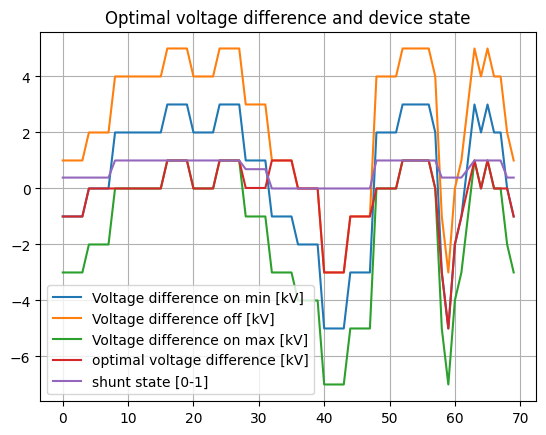

In [296]:
print("Payout with optimal decisions: %s" % statepayouts[start, 0])

plt.figure().clear()
plt.title("Optimal voltage difference and device state")
plt.plot(data['dV_on_min'], label='Voltage difference on min [kV]')
plt.plot(data['dV_off'], label='Voltage difference off [kV]')
plt.plot(data['dV_on_max'], label='Voltage difference on max [kV]')
plt.plot(optimal_voltages, label="optimal voltage difference [kV]")
plt.plot(device_state, label="shunt state [0-1]")
plt.legend()
plt.grid()
plt.show()